# Предсказание победителя в онлайн-игре

Работу выполнил: Королев Егор, студент 4-го курса НИУ МАИ факультет информационных технологий и прикладной математики.  
Группа: М8О-401Б-18.  
Работа выполнялась, исходя из 2 целей: выполнение лабораторных работ по курсу Искусственного интеллекта в МАИ, а также как финальное задание курса Введение в машинное обучение на Coursera.  
Были рассмортрены следующие методы машинного обучения:  
* метод k-ближайших соседей;
* наивный байесовский классификатор;
* логистическая регрессия;
* дерево решений;
* SVM;
* Случайный лес;
* Градиентный бустинг.

Решение задачи было отправлено на соревнование Kaggle (kaggle score = 0.75522).  
https://www.kaggle.com/c/dota-2-win-probability-prediction/submissions

In [2]:
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import json
import bz2

import time
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from collections import Counter

## Постановка задачи

Построить предсказательную систему выигрыша команды в игре Dota2 по первым 5 минутам игры.

## Описание данных

Все множество пар признаков/ответов находится в сжатом файле src/data/matches.jsonlines.bz2. Файл содержит объекты в формате JSON.

Каждый объект записи матча содержит следующие поля:  
* match_id - идентификатор матча
* start_time - дата/время начала матча, unixtime
* lobby_type - тип комнаты, в которой собираются игроки
* picks_bans - структурный объект для обозначения стадии выбора героев
* players - информация про каждого игрока (id героя, временные ряды опыта, золота + стоимости всех купленных вещей, кол-во убитых юнитов противника, список событий (улучшение способностей героя, убийства, покупка предметов, выкуп героя из таверны, утсановка "наблюдателей"))
* times - отсчеты игрового времени, в которые вычисляются значения временных рядов, например [0,60,120,180,240,...]
* objectives - ключевые события игры (время события, тип события,индексы игроков, номер команды)
* finish - итог матча (длительность в секундах, победившая команда, состояние башен, состояние бараков)

Состояние башен к концу игры задается целым числом, закодировано в битах:

```
┌─┬─┬─┬─┬─────────────────────── Not used.
│ │ │ │ │ ┌───────────────────── Ancient Bottom
│ │ │ │ │ │ ┌─────────────────── Ancient Top
│ │ │ │ │ │ │ ┌───────────────── Bottom Tier 3
│ │ │ │ │ │ │ │ ┌─────────────── Bottom Tier 2
│ │ │ │ │ │ │ │ │ ┌───────────── Bottom Tier 1
│ │ │ │ │ │ │ │ │ │ ┌─────────── Middle Tier 3
│ │ │ │ │ │ │ │ │ │ │ ┌───────── Middle Tier 2
│ │ │ │ │ │ │ │ │ │ │ │ ┌─────── Middle Tier 1
│ │ │ │ │ │ │ │ │ │ │ │ │ ┌───── Top Tier 3
│ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─── Top Tier 2
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─ Top Tier 1
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
```

Состояние бараков к концу игры закодировано в битах целого числа:

```
┌─┬───────────── Not used.
│ │ ┌─────────── Bottom Ranged
│ │ │ ┌───────── Bottom Melee
│ │ │ │ ┌─────── Middle Ranged
│ │ │ │ │ ┌───── Middle Melee
│ │ │ │ │ │ ┌─── Top Ranged
│ │ │ │ │ │ │ ┌─ Top Melee
│ │ │ │ │ │ │ │
0 0 0 0 0 0 0 0
```

Для примера выведу информацию об игроках в первом матче выборки:

In [126]:
with bz2.BZ2File('./src/data/matches.jsonlines.bz2', mode='r') as matches_file:
    match_1 = json.loads(matches_file.readline())
    print(match_1["players"])

[{'buyback_log': [{'key': None, 'time': 2507}], 'lh_t': [0, 2, 7, 14, 20, 28, 33, 40, 45, 50, 57, 64, 68, 74, 76, 80, 89, 92, 92, 97, 97, 112, 115, 123, 124, 132, 146, 152, 166, 180, 180, 183, 185, 189, 201, 220, 225, 231, 253, 261, 275, 283, 293, 296, 296, 306, 319, 337, 347, 364, 365], 'obs_log': [], 'purchase_log': [{'item_id': 44, 'time': -73}, {'item_id': 16, 'time': -72}, {'item_id': 182, 'time': -71}, {'item_id': 39, 'time': -68}, {'item_id': 16, 'time': -66}, {'item_id': 14, 'time': 43}, {'item_id': 71, 'time': 43}, {'item_id': 14, 'time': 43}, {'item_id': 29, 'time': 175}, {'item_id': 54, 'time': 783}, {'item_id': 46, 'time': 847}, {'item_id': 137, 'time': 984}, {'item_id': 46, 'time': 1049}, {'item_id': 46, 'time': 1128}, {'item_id': 22, 'time': 1187}, {'item_id': 22, 'time': 1208}, {'item_id': 46, 'time': 1296}, {'item_id': 46, 'time': 1320}, {'item_id': 46, 'time': 1538}, {'item_id': 19, 'time': 1552}, {'item_id': 174, 'time': 1606}, {'item_id': 22, 'time': 1870}, {'item_id

Скрипт extract_features.py извлекает часть признаков за первые 5 минут игры из файла matches.jsonlines. И составляет таблицу из этих данных.  
features.csv содержит наиболее важные признаки для решения задачи.

## Предварительный анализ данных

Загрузка данных и вывод первых записей:

In [67]:
df = pd.read_csv("./src/data/features.csv", index_col="match_id")

In [128]:
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


Основные статистики по признакам:

In [129]:
df.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,...,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,...,1.155609,0.813459,0.710122,40.701397,715.806850,0.499660,853.921365,851.009148,27.871645,27.064873
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-84.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,...,3.000000,2.000000,0.000000,-31.000000,1818.000000,0.000000,36.000000,256.000000,3.000000,3.000000
50%,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,...,3.000000,2.000000,1.000000,-16.000000,2268.000000,1.000000,1824.000000,1798.000000,63.000000,60.000000
75%,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,...,4.000000,3.000000,1.000000,8.000000,2778.000000,1.000000,1974.000000,1974.000000,63.000000,63.000000
max,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,...,9.000000,9.000000,13.000000,300.000000,8452.000000,1.000000,2047.000000,2047.000000,63.000000,63.000000


Вывод распределений полученного золота игроками команды radiant за первые 5 минут игры:

(array([2.8700e+02, 3.0391e+04, 2.6927e+04, 2.2499e+04, 1.2967e+04,
        3.2620e+03, 7.1400e+02, 1.5200e+02, 2.7000e+01, 4.0000e+00]),
 array([   0.,  384.,  768., 1152., 1536., 1920., 2304., 2688., 3072.,
        3456., 3840.]),
 <BarContainer object of 10 artists>)

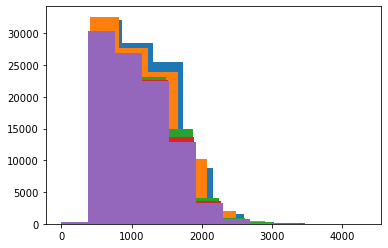

In [130]:
plt.hist(df["r1_gold"])
plt.hist(df["r2_gold"])
plt.hist(df["r3_gold"])
plt.hist(df["r4_gold"])
plt.hist(df["r5_gold"])

Гистограма события first_blood за первые 5 минут игры:

(array([   46.,  7539., 14445., 10416., 12728., 11354.,  8900.,  5372.,
         4016.,  2861.]),
 array([-78. , -40.2,  -2.4,  35.4,  73.2, 111. , 148.8, 186.6, 224.4,
        262.2, 300. ]),
 <BarContainer object of 10 artists>)

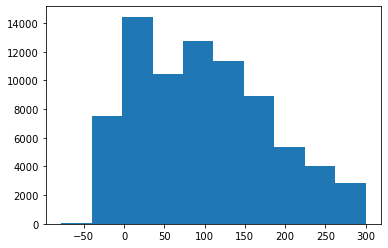

In [131]:
plt.hist(df["first_blood_time"])

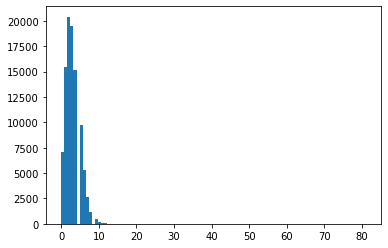

In [132]:
plt.hist(df["radiant_tpscroll_count"], bins=100);

Посмотрим, как влияют отдельные признаки на итог матча.

<AxesSubplot:xlabel='first_blood_team', ylabel='count'>

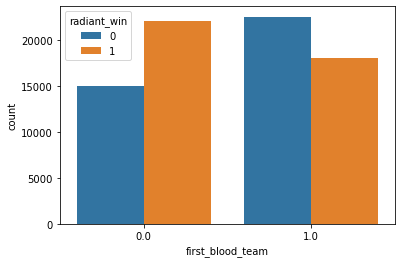

In [133]:
sns.countplot(x='first_blood_team', hue='radiant_win', data=df)

Из графика выше видно, что частота выигрыша выше у команды с "первой кровью".

<AxesSubplot:xlabel='radiant_tpscroll_count', ylabel='count'>

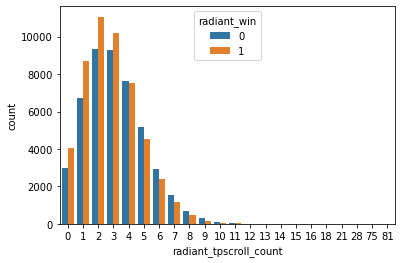

In [134]:
sns.countplot(x='radiant_tpscroll_count',hue='radiant_win', data=df)

radiant_tpscroll_count: число предметов "tpscroll" за первые 5 минут. Можно заметить, что графики напоминают Пуассоновское распределение. Из графика видно, если radiant приобретают за первые 5 минут игры до 4 предметов "tpscroll", то их шансы на победу несколько выше, чем у другой команды. Аналогичный график выглядит для dire_tpscroll_count, следовательно, если команда купила данного товара менее 4 штук, то статистически у нее больше шансов на победу

## Проверка на пропуски в данных

In [135]:
count_na = len(df) - df.count()  # список количества пропусков по различным признакам
count_na[count_na > 0].sort_values(ascending=False) / len(df)  # вычисление частоты и сортировка по убыванию

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

* first_blood_player2 - 45 % пропусков. Обуславливается тем, что first_blood не было в первые 5 минут игры.  
* radiant_flying_courier_time (dire_flying_courier_time) - в 28 % (26.8 %) случаев товар не покупается за первые 5 минут игры.  
* first_blood_time - 20 % пропусков. Обуславливается тем, что в 20 % случаев на first_blood уходит более 5 минут.  
* first_blood_team - 20 % пропусков, так же как и в first_blood_time.  
* first_blood_player1 - 20 % пропусков, так же как и в first_blood_time.  
* dire_bottle_time (radiant_bottle_time) - 16.7 % (16.1 %) пропусков. За первые 5 минут bottle не покупается в 16.7 % (16.1 %) случаев.  
* radiant_first_ward_time (radiant_courier_time) - 1.8 % пропусков. В 1.8 % случаев ward не ставится в первые 5 минут.
* radiant_courier_time (dire_courier_time) - 0.7 % пропусков. В 0.7 % случаев courier не покупается.
* в остальных признаках пропусков нет.

Заполним пропуски в данных на нулевые значения и выкинем из датасета те признаки, которые позволяют "заглянуть в будущее" матча, и следовательно, приведут к эффекту переобучения

In [55]:
df.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

In [56]:
df.fillna(0, inplace=True)

* Для логистической регрессии наиболее предпочтительнее является замена пропусков нулями, так как пропущенные значения не будут влиять на предсказание.    
* Для деревьев предпочтительнее является замена пропусков крайне большими или крайне низкими значениями, это приведет к выделению в отдельную ветку объектов с пропусками.  
* Существуют другие способы борьбы с пропусками: замена на среднее, мединное значение или удаление объектов с пропусками из выборки.  

В данной работе для всех методов использовалась техника замены пропусков на нулевые значения

Отделим матрицу объекты-признаки и вектор ответов:

In [57]:
X_train = df.drop("radiant_win", axis=1)
y_train = df["radiant_win"]

# Градиентный бустинг

Будем использовать кросс-валидацию по 5-ти блокам с перемешиванием (shuffle=True).

In [139]:
cv = KFold(n_splits=5, shuffle=True)

In [122]:
scores = []
ns = [1,2,4,8,16,32,64,128,256]
for n in ns:
    time1 = datetime.datetime.now()
    print("n =", n)
    model = GradientBoostingClassifier(n_estimators=n)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print("score = ", score)
    time2 = datetime.datetime.now()
    print("time: ", str(time2 - time1), "\n")

n = 1
score =  0.5949428103970147
time:  0:00:04.243297 

n = 2
score =  0.6101524765684168
time:  0:00:07.828822 

n = 4
score =  0.6274441686253021
time:  0:00:15.290887 

n = 8
score =  0.6575961363771674
time:  0:00:29.931828 

n = 16
score =  0.6779531118136995
time:  0:00:59.849773 

n = 32
score =  0.6906379311653914
time:  0:01:59.661435 

n = 64
score =  0.701215131910532
time:  0:03:59.343580 

n = 128
score =  0.7093229593339576
time:  0:07:58.682482 

n = 256
score =  0.7164673745817715
time:  0:15:29.024693 



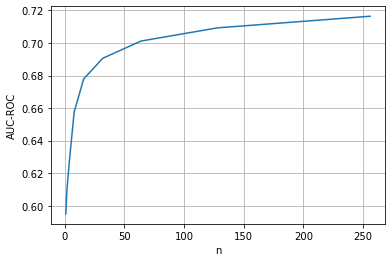

In [123]:
plt.plot(ns, scores)
plt.xlabel("n")
plt.ylabel("AUC-ROC")
plt.grid()

Из графика видно, что функция при увеличении n (количества деревьев в градиентном бустинге) замедляет рост, при увеличении числа деревьев до 1000 или до 2000 значение метрики было бы 73-74 %, но для этого пришлось бы ждать ~ 1-2 часа.

Для ускорения метода можно было бы ограничить максимальную глубину деревьев или обучаться на выборке меньшего размера

# Логистическая регрессия

Рассмотрим модель логистической регрессии на всех данных (включая категориальные). При этом проведем кросс-валидацию по значению параметра регуляризации

In [275]:
X_train = StandardScaler().fit_transform(X_train)

In [166]:
scores = []
cs = [10**i for i in range(-5,5,1)]
for c in cs:
    time1 = datetime.datetime.now()
    print("с =", c)
    model = LogisticRegression(C=c)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='AUC-ROC').mean()
    scores.append(score)
    print("score = ", score)
    time2 = datetime.datetime.now()
    print("time: ", str(time2 - time1), "\n")

с = 1e-05
score =  0.6951123612404949
time:  0:00:02.493493 

с = 0.0001
score =  0.711218995539846
time:  0:00:02.001518 

с = 0.001
score =  0.7161787436895245
time:  0:00:03.794763 

с = 0.01
score =  0.7162523586955885
time:  0:00:04.759260 

с = 0.1
score =  0.7165202132137741
time:  0:00:04.745341 

с = 1
score =  0.7163127367495672
time:  0:00:05.152277 

с = 10
score =  0.716469023302449
time:  0:00:05.127257 

с = 100
score =  0.7163794518340204
time:  0:00:05.048785 

с = 1000
score =  0.7164750958962124
time:  0:00:05.007788 

с = 10000
score =  0.716189946299956
time:  0:00:04.946919 



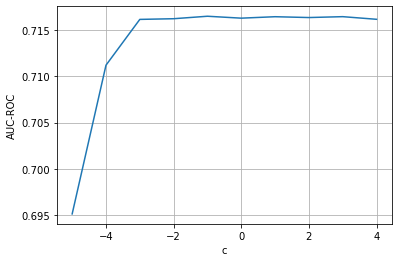

In [167]:
plt.plot(range(-5,5,1), scores)
plt.xlabel("c")
plt.ylabel("AUC-ROC")
plt.grid()

In [168]:
print(max(scores))
print("Наилучшее значение с =",0.1)

0.7165202132137741
Наилучшее значение с = 0.1


Удалось достичь значения 0.7165 по AUC-ROC данное значение немного меньше, чем в градиентном бустинге, однако обучение модули произошло в ~ 250 раз быстрее это достигается за счет того, что линейные методы работают быстрее.

## Логистическая регрессия без категориальных признаков

У предыдущей модели был существенный недостаток - датасет включал категориальные признаки, модель обучалась на них, но логистическая регрессия плохо работает с такими признаки, поэтому в следующей модели исключим их из воборки и посмотрим как это повлияет на значение метрики.

In [222]:
df = pd.read_csv("./src/data/features.csv", index_col="match_id")
df.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
    "r1_hero",
    "r2_hero",
    "r3_hero",
    "r4_hero",
    "r5_hero",
    "d1_hero",
    "d2_hero",
    "d3_hero",
    "d4_hero",
    "d5_hero",
    "lobby_type",
], axis=1, inplace=True)
df.fillna(0, inplace=True)
y_train = df["radiant_win"]
X_train = df.drop(["radiant_win"], axis=1)
X_train = StandardScaler().fit_transform(X_train)

In [334]:
scores = []
cs = [10**i for i in range(-5,5,1)]
for c in cs:
    time1 = datetime.datetime.now()
    print("c =", c)
    model = LogisticRegression(C=c)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print("score = ", score)
    time2 = datetime.datetime.now()
    print("time: ", str(time2 - time1), "\n")

c = 1e-05
score =  0.6950491860225302
time:  0:00:02.136370 

c = 0.0001
score =  0.7111761802754375
time:  0:00:02.077134 

c = 0.001
score =  0.7162966645155926
time:  0:00:03.558279 

c = 0.01
score =  0.7165796342141715
time:  0:00:04.458192 

c = 0.1
score =  0.716448810715135
time:  0:00:04.528776 

c = 1
score =  0.7165965382706967
time:  0:00:04.447099 

c = 10
score =  0.7164275264135043
time:  0:00:04.499036 

c = 100
score =  0.7165702803508898
time:  0:00:04.810460 

c = 1000
score =  0.7164129282464565
time:  0:00:04.683660 

c = 10000
score =  0.7164286859894101
time:  0:00:04.749825 



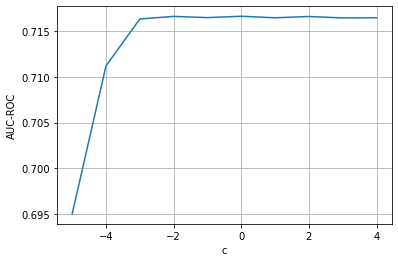

In [335]:
plt.plot(range(-5,5,1), scores)
plt.xlabel("c")
plt.ylabel("AUC-ROC")
plt.grid()

In [337]:
print(max(scores))
print("Наилучшее значение с =",1)

0.7165965382706967
Наилучшее значение с = 1


Как видим удаление категориальных признаков не привело к изменению метрики качества, это можно объяснить тем, что модель распознала шум.

## Ценность категориальных признаков в данной задаче

На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки - герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие.

In [8]:
unique_heroes = np.unique(df[[
    "r1_hero",
    "r2_hero",
    "r3_hero",
    "r4_hero",
    "r5_hero",
    "d1_hero",
    "d2_hero",
    "d3_hero",
    "d4_hero",
    "d5_hero",
]].values.ravel())
print("Уникальных героев:", len(unique_heroes))
print("В одной игре 10 уникальных героев")
print("Max ID =", max(unique_heroes))

Уникальных героев: 108
В одной игре 10 уникальных героев
Max ID = 112


## Воспользуемся подходом "мешок слов" для кодирования информации о героях.

Пусть всего в игре имеется N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. При этом в одном матче не могут быть 2-х разных игроков с одинаковыми героями.

In [44]:
N = len(unique_heroes)
X = np.zeros((df.shape[0], max(unique_heroes)))
for i, match_id in enumerate(df.index):
    for hero_id in range(5): # for all heros
        X[i, df.loc[match_id, 'r%d_hero' % (hero_id + 1)] - 1] = 1
        X[i, df.loc[match_id, 'd%d_hero' % (hero_id + 1)] - 1] = -1

In [68]:
df.drop([
    "lobby_type",
    "r1_hero",
    "r2_hero",
    "r3_hero",
    "r4_hero",
    "r5_hero",
    "d1_hero",
    "d2_hero",
    "d3_hero",
    "d4_hero",
    "d5_hero",
],axis = 1, inplace = True)

In [69]:
X_train = np.hstack((df.values, X))

In [70]:
X_train = StandardScaler().fit_transform(X_train)

In [214]:
scores = []
cs = [10**i for i in range(-5,5,1)]
for c in cs:
    time1 = datetime.datetime.now()
    print("с =", c)
    model = LogisticRegression(C=c)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print("score = ", score)
    time2 = datetime.datetime.now()
    print("time: ", str(time2 - time1), "\n")

с = 1e-05
score =  0.7148340605898584
time:  0:00:02.082909 

с = 0.0001
score =  0.7427043031323926
time:  0:00:02.455098 

с = 0.001
score =  0.7514374526568861
time:  0:00:04.871962 

с = 0.01
score =  0.7517832181347623
time:  0:00:06.944595 

с = 0.1
score =  0.7519512329930921
time:  0:00:08.229987 

с = 1
score =  0.7518565664263381
time:  0:00:07.826936 

с = 10
score =  0.7520934775236281
time:  0:00:08.389247 

с = 100
score =  0.7519386229900586
time:  0:00:07.909559 

с = 1000
score =  0.751975404686901
time:  0:00:08.188655 

с = 10000
score =  0.7517459573322497
time:  0:00:08.042154 



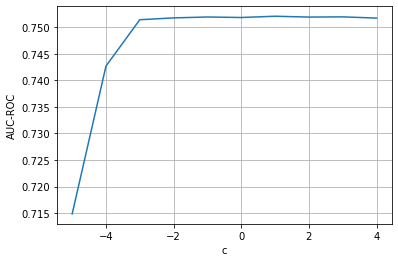

In [216]:
plt.plot(range(-5,5,1), scores)
plt.xlabel("c")
plt.ylabel("AUC-ROC")
plt.grid()

С добавлением мешка слов значение AUC-ROC существенно увеличелось, при c=10 ROC-AUC = 0.752. Из значения данной метрики следует, что модель хорошо описывается линейными методами

## Своя реализация логистической регрессии

In [52]:
class MyLogisticRegression:
    def __init__(self, step=1e-1, n_iter=100):
        self.step = step
        self.n_iter = n_iter

    def logistic_function(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y):
        x = np.hstack((np.ones((X.shape[0], 1)), X))
        self._weights = np.zeros(x.shape[1])
        for i in range(self.n_iter):
            z = np.dot(x, self._weights)
            gradient = np.dot(x.T, self.logistic_function(z) - Y) / Y.size
            self._weights -= self.step * gradient

    def predict(self, X):
        x = np.array([X])
        x = np.hstack((np.ones((x.shape[0], 1)), x))
        return self.logistic_function(np.dot(x, self._weights)).round()

    def score(self, features, y):
        TP = TN = FP = FN = 0
        right_predict_number = 0
        r_m = min(len(y), features.shape[0])
        for i in range(r_m):
            pred = self.predict(features[i])
            if y[i] == 1:
                if pred == 1:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred == 1:
                    FP += 1
                else:
                    TN += 1
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        return {'recall': recall, 'precision': precision, 'accuracy': accuracy}

In [60]:
y_train = np.array(y_train)
X_train = np.array(X_train)
model = MyLogisticRegression()
model.fit(X_train, y_train)
print('my implementation LR: ', model.score(X_train, y_train))

my implementation LR:  {'recall': 0.6863172928154878, 'precision': 0.6609107579462102, 'accuracy': 0.6547773320991463}


## Построим предсказание вероятностей победы команды Radiant

In [376]:
# data prepare
df = pd.read_csv("./src/data/features.csv", index_col="match_id")
df.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
    'radiant_win',
], axis=1, inplace=True)
df.fillna(0, inplace=True)

heros = [
    "r1_hero",
    "r2_hero",
    "r3_hero",
    "r4_hero",
    "r5_hero",
    "d1_hero",
    "d2_hero",
    "d3_hero",
    "d4_hero",
    "d5_hero",
]

unique_heroes = np.unique(df[heros].values.ravel())
N = len(unique_heroes)
X = np.zeros((df.shape[0], max(unique_heroes)))
for i, match_id in enumerate(df.index):
    for hero_id in range(5): # for all heros
        X[i, df.loc[match_id, 'r%d_hero' % (hero_id + 1)] - 1] = 1
        X[i, df.loc[match_id, 'd%d_hero' % (hero_id + 1)] - 1] = -1
df.drop(heros + ['lobby_type'], axis=1, inplace=True)
X_train = np.hstack((df.values, X))
X_train = StandardScaler().fit_transform(X_train)


# data test prepare
df_test = pd.read_csv('./src/data/features_test.csv',index_col='match_id')
df_test.fillna(0,inplace = True)

X = np.zeros((df_test.shape[0], max(unique_heroes)))
for i, match_id in enumerate(df_test.index):
    for hero_id in range(5): # for all heros
        X[i, df_test.loc[match_id, 'r%d_hero' % (hero_id + 1)] - 1] = 1
        X[i, df_test.loc[match_id, 'd%d_hero' % (hero_id + 1)] - 1] = -1        
df_test.drop(heros + ['lobby_type'], axis=1, inplace=True)
X_test = np.hstack((df_test.values, X))
X_test = StandardScaler().fit_transform(X_test)

In [227]:
model = LogisticRegression(C=10)
model.fit(X_train, y_train)

LogisticRegression(C=10)

In [228]:
pred = model.predict_proba(X_test)

In [230]:
print(pred)

[[0.1750309  0.8249691 ]
 [0.24143025 0.75856975]
 [0.81297053 0.18702947]
 ...
 [0.76885311 0.23114689]
 [0.36797371 0.63202629]
 [0.57402582 0.42597418]]


Уберем лишний столбец

In [231]:
pred = [pred[i][1] for i in range(0,len(pred))]

Выведем граничные значения, убедимся, что они лежат в отрезке [0,1]

In [342]:
print("max pred =", max(pred))
print("min pred =", min(pred))

max pred = 0.9964864194103671
min pred = 0.008694489660680121


Построим гистограмму точности прогнозов

(array([ 420., 1177., 1785., 2265., 2425., 2504., 2461., 2076., 1541.,
         523.]),
 array([0.00869449, 0.10747368, 0.20625288, 0.30503207, 0.40381126,
        0.50259045, 0.60136965, 0.70014884, 0.79892803, 0.89770723,
        0.99648642]),
 <BarContainer object of 10 artists>)

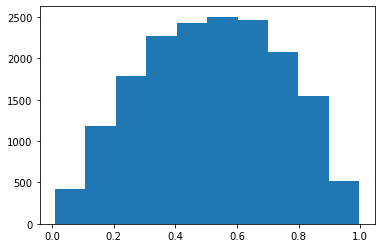

In [343]:
plt.hist(pred)

В данной задаче логистическая регрессия с мешком слов для категориальных признаков дает более лучшее значение метрики, чем градиентный бустинг. Причем логистическая регрессия работает существенно быстрее 8 секунд, против 15.5 минут. Скорость работы обуславливается тем, что линейные методы обучаются гораздо быстрее. Точность можно объяснить тем, что данный набор данных хорошо описывается линейными моделями.

Создадим файл для kaggle-соревнования

In [245]:
pd.DataFrame(
    data = pred,
    index = df_test.index,
    columns=['radiant_win']
).to_csv('kaggle.csv')

kaggle score = 0.75522

# Метод k-ближайших соседей

Рассмортим метод k-ближайших соседей. Данный метод метрический, поэтому введем метрику расстояния:

In [149]:
def euclidean_norma(a, b):
    return sum([(x - y) ** 2 for x, y in zip(a, b)]) ** 0.5

In [158]:
class KNN:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, object_pred, k, metric):
        ns = np.zeros((self.X.shape[0], 2))
        for i in range(self.X.shape[0]):
            ns[i] = (metric(object_pred, self.X[i]), self.y[i])
        sorted_ns = sorted(ns, key=lambda x: x[0])[:k]
        cnt_0, cnt_1 = 0, 0
        for _, y in sorted_ns:
            if y == 1:
                cnt_1 += 1
            else:
                cnt_0 += 1
        return 1 if cnt_1 > cnt_0 else 0
    
    def score(self, features, y, k, metric):
        TP = TN = FP = FN = 0
        right_predict_number = 0
        for i in range(features.shape[0]):
            pred = self.predict(features[i], k, metric)
            if y[i] == 1:
                if pred == 1:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred == 1:
                    FP += 1
                else:
                    TN += 1
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        return {'recall': recall, 'precision': precision, 'accuracy': accuracy}

In [159]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, shuffle=True)
y_train_new = np.array(y_train_new)[:1000]
y_test_new = np.array(y_test_new)[:1000]
X_train_new = np.array(X_train_new)[:1000]
X_test_new = np.array(X_test_new)[:1000]

0.543

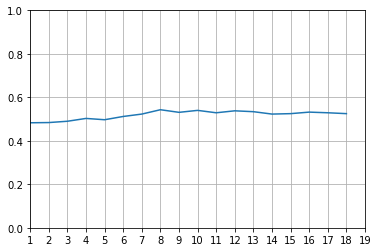

In [166]:
scores = []
for k in range(1,20,1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_new, y_train_new)
    scores.append(knn.score(X_test_new, y_test_new))
plt.plot(scores)
plt.xlim([1, 18])
plt.ylim([0, 1.0])
plt.xticks(list(range(1, 20, 1)))
plt.grid()
max(scores)

In [162]:
knn_obj = KNN(X_train_new, y_train_new)
print('my implementation KNN. train sample: ', knn_obj.score(X_train_new, y_train_new, 9, euclidean_norma))
print('my implementation KNN. test sample: ', knn_obj.score(X_test_new, y_test_new, 9, euclidean_norma))

my implementation KNN: test sample:  {'recall': 0.6883365200764818, 'precision': 0.6050420168067226, 'accuracy': 0.602}
my implementation KNN: train sample:  {'recall': 0.6125954198473282, 'precision': 0.5582608695652174, 'accuracy': 0.543}


# Наивный баейсовский классификатор

In [177]:
class NormalDistribution:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def probability_density(self, value):
        eps = 1e-5
        return 1 / (eps + self.std * (2 * np.pi) ** 0.5 * np.exp((value - self.mean) ** 2 / (eps + 2 * self.std ** 2)))

In [169]:
class NaiveBayes:
    def fit(self, X, Y):
        self.label_probabilities = {
            0: len(Y[Y == 0]) / len(Y),
            1: len(Y[Y == 1]) / len(Y)
        }
        self.conditional_probabilities = {}
        for value in (0, 1):
            probabilities = []
            for column in range(X.shape[1]):
                x = X[Y == value, column]
                probabilities.append(NormalDistribution(x.mean(axis=0), x.std(axis=0)))
            self.conditional_probabilities[value] = probabilities
    
    def predict(self, feature):
        label_probabilities = {}
        for value in (0, 1):
            conditional_feature_probability = 0
            for i in range(feature.shape[0]):
                conditional_feature_probability += np.log(self.conditional_probabilities[value][i].probability_density(feature[i]))
            label_probabilities[value] = np.log(self.label_probabilities[value]) + conditional_feature_probability
        return 1 if label_probabilities[1] > label_probabilities[0] else 0

    def score(self, features, y):
        TP = TN = FP = FN = 0
        right_predict_number = 0
        for i in range(features.shape[0]):
            pred = self.predict(features[i])
            if y[i] == 1:
                if pred == 1:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred == 1:
                    FP += 1
                else:
                    TN += 1
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        return {'recall': recall, 'precision': precision, 'accuracy': accuracy}

In [170]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train, 
                                                                            test_size=0.2, random_state=24)
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)
X_train_new = np.array(X_train_new)
X_test_new = np.array(X_test_new)

In [179]:
sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(X_train_new, y_train_new)
print('sklearn NaiveBayes: ', sklearn_nb.score(X_train_new, y_train_new))

sklearn NaiveBayes:  0.6502108402756351


In [176]:
nb = NaiveBayes()
nb.fit(X_train_new, y_train_new)
print('my implementation NaiveBayes. train sample: ', nb.score(X_train_new, y_train_new))
print('my implementation NaiveBayes. test sample: ', nb.score(X_test_new, y_test_new))

<ipython-input-175-81e5919c60fc>:8: RuntimeWarning: overflow encountered in exp
  return 1 / (eps + self.std * (2 * np.pi) ** 0.5 * np.exp((value - self.mean) ** 2 / (eps + 2 * self.std ** 2)))
<ipython-input-169-26d004fca350>:20: RuntimeWarning: divide by zero encountered in log
  conditional_feature_probability += np.log(self.conditional_probabilities[value][i].probability_density(feature[i]))


my implementation NaiveBayes: test sample:  {'recall': 0.637486054295277, 'precision': 0.6470795480282859, 'accuracy': 0.6317237478144606}
my implementation NaiveBayes: train sample:  {'recall': 0.6346859807520587, 'precision': 0.6503660024400163, 'accuracy': 0.6338064383420755}


# SVM

In [ ]:
class my_SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=10000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters

    def fit(self, X, y):
        # переименовываем лейблы в -1 и 1
        y_ = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape

        self.W = np.zeros(n_features)
        self.b = 0

        # процесс обучения (настройка весов и смещения)
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * ((x_i @ self.W) - self.b) >= 1
                if condition:
                    self.W -= self.lr * (2 * self.lambda_param * self.W)
                else:
                    self.W -= self.lr * (2 * self.lambda_param * self.W - np.dot(x_i,y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        res = np.dot(X, self.W) - self.b
        # предсказываем класс в зависимости от знака
        return np.where(res >= 0, 1, 0)

# Деревья решений

In [193]:
class Tree:
    class Node:
        def __init__(self, isLeaf=False, feature_index=None, split_value=None, sons=None, value=None):
            self.isLeaf = isLeaf
            if not isLeaf:
                self.feature_index = feature_index
                self.split_value = split_value
                self.sons = sons
                self.left = None
                self.right = None
            else:
                self.value = value

    def __init__(self, max_depth, min_size):
        self.max_depth = max_depth  # максимальная глубина деревьев
        self.min_size = min_size  # минимальная глубина деревьев
        
    def split(self, XY):
        unique_targets = list(set(row[-1] for row in XY))
        feature_index, split_value, subtrees = None, None, None
        min_gini_id = 100
        
        for i in range(XY.shape[1] - 1):
            for row in XY:
                s_trees = self.__get_subtrees(i, row[i], XY)
                gini_id = self.__gini_index(s_trees, unique_targets)
                if gini_id < min_gini_id:
                    feature_index, split_value, subtrees = i, row[i], s_trees
                    min_gini_id = gini_id
                    
        return Tree.Node(feature_index=feature_index, split_value=split_value, sons=subtrees)

    def make_tree(self, XY):
        root = self.split(XY)
        self.recursive_split(root, 1)
        self.root = root

    def __get_subtrees(self, index, value, XY):
        left, right = [], []
        for row in XY:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def __gini_index(self, subtrees, unique_targets):
        n_instances_in_subtrees = sum([len(subtree) for subtree in subtrees])
        result = 0.
        for subtree in subtrees:
            n_instances_in_subtree = len(subtree)
            if n_instances_in_subtree == 0:
                continue
            score = 0.
            for target in unique_targets:
                probability = [row[-1] for row in subtree].count(target) / n_instances_in_subtree
                score += probability ** 2
            result += (1. - score) * (n_instances_in_subtree / n_instances_in_subtrees)
        return result

    def recursive_split(self, node, depth):
        left, right = node.sons
        node.sons = None
        if not left.tolist() or not right.tolist():
            node.left = node.right = self.make_leaf(left.tolist() + right.tolist())
            return
        if depth >= self.max_depth:
            node.left, node.right = self.make_leaf(left), self.make_leaf(right)
            return
        
        if len(left) <= self.min_size:
            node.left = self.make_leaf(left)
        else:
            node.left = self.split(left)
            self.recursive_split(node.left, depth + 1)
        
        if len(right) <= self.min_size:
            node.right = self.make_leaf(right)
        else:
            node.right = self.split(right)
            self.recursive_split(node.right, depth + 1)

    def make_leaf(self, subtree):
        targets = [row[-1] for row in subtree]
        return Tree.Node(isLeaf=True, value=max(targets, key=targets.count))

class MyDecisionTreeClassifier:
    
    def __init__(self, max_depth=7, min_size=3):
        self.tree = Tree(max_depth, min_size)

    def fit(self, X, Y):
        self.tree.make_tree(np.column_stack((X, Y)))

    def predict(self, x):
        return self.__predict_help(self.tree.root, x)

    def __predict_help(self, node, row):
        if row[node.feature_index] < node.split_value:
            if not node.left.isLeaf:
                return self.__predict_help(node.left, row)
            else:
                return node.left.value
        else:
            if not node.right.isLeaf:
                return self.__predict_help(node.right, row)
            else:
                return node.right.value         
    
    def score(self, features, y):
        TP = TN = FP = FN = 0
        right_predict_number = 0
        for i in range(features.shape[0]):
            pred = self.predict(features[i])
            if y[i] == 1:
                if pred == 1:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred == 1:
                    FP += 1
                else:
                    TN += 1
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        return {'recall': recall, 'precision': precision, 'accuracy': accuracy}

In [185]:
dt = DecisionTreeClassifier()
dt.fit(X_train_new, y_train_new)
print('sklearn NaiveBayes: ', dt.score(X_test_new, y_test_new))

sklearn NaiveBayes:  0.6009976344749562


In [194]:
upper_bound = 1000
mdt = MyDecisionTreeClassifier()
mdt.fit(X_train_new[:upper_bound], y_train_new[:upper_bound])
print('my implementation DecisionTreeClassifier. train sample: ', mdt.score(X_train_new[:upper_bound], y_train_new[:upper_bound]))
print('my implementation DecisionTreeClassifier. test sample: ', mdt.score(X_test_new[:upper_bound], y_test_new[:upper_bound]))

my implementation DecisionTreeClassifier. test sample:  {'recall': 0.8822393822393823, 'precision': 0.8017543859649123, 'accuracy': 0.826}
my implementation DecisionTreeClassifier. train sample:  {'recall': 0.6640471512770137, 'precision': 0.5767918088737202, 'accuracy': 0.581}


# Случайный лес

In [195]:
class MyRandomForest:
    def __init__(self, max_depth=7, n_classifiers=30):
        self.max_depth = max_depth
        self.n_classifiers = n_classifiers
        self.classifiers = []
        self.features_indexes = []
        self.x, self.y = None, None

    def fit(self, X, Y):
        self.x, self.y = X, Y
        n_select_features = int(np.sqrt(self.x.shape[1]))
        for _ in range(self.n_classifiers):
            x, y = resample(self.x, self.y, n_samples=len(self.y))
            
            seq_features = [n for n in range(x.shape[1])]
            new_x = []
            for _ in range(n_select_features):
                val = random.choice(seq_features)
                new_x.append(val)
                seq_features.remove(val)
            self.features_indexes.append(new_x)
            tree = MyDecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(x[:,np.array(new_x)], y)
            self.classifiers.append(tree)

    def predict(self, X):
        pred = [classifier.predict(X[np.array(self.features_indexes[i])]) for i, classifier in enumerate(self.classifiers)]
        c = Counter(pred)
        return c.most_common(1)[0][0]

    def score(self, features, y):
        TP = TN = FP = FN = 0
        right_predict_number = 0
        for i in range(features.shape[0]):
            pred = self.predict(features[i])
            if y[i] == 1:
                if pred == 1:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred == 1:
                    FP += 1
                else:
                    TN += 1
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        return {'recall': recall, 'precision': precision, 'accuracy': accuracy}

In [196]:
dt = RandomForestClassifier(n_estimators=100)
dt.fit(X_train_new, y_train_new)
print('sklearn RandomForest: ', dt.score(X_test_new, y_test_new))

sklearn RandomForest:  0.6395145531214645


In [197]:
upper_bound = 500
mrf = MyRandomForest(max_depth=5, n_classifiers=100)
mrf.fit(X_train_new[:upper_bound], y_train_new[:upper_bound])
print('my implementation RandomForest. train sample: ', mrf.score(X_train_new[:upper_bound], y_train_new[:upper_bound]))
print('my implementation RandomForest. test sample: ', mrf.score(X_test_new[:upper_bound], y_test_new[:upper_bound]))

my implementation RandomForest. test sample:  {'recall': 1.0, 'precision': 0.8770226537216829, 'accuracy': 0.924}
my implementation RandomForest. train sample:  {'recall': 0.9057377049180327, 'precision': 0.5175644028103045, 'accuracy': 0.542}


# Выводы

В работе были рассмотренно множество алгоритмов машинного обучения, для некоторых алгоритмов была сделана собственная реализация. Наилучшим методом оказалась логистическая регрессия с мешком слов, точность модели оказалась примерно равной 75%. Работа была отправлена на соревнование Kaggle и получила рейтинг 0.75522, большая часть участников соревнования также набрала рейтинг в окрестности 0.75.